### Summary of Findings

- Mean reconstruction error tends to dilute localized defects.
- Max reconstruction error improves separation between normal and defective samples.
- Max-based scoring achieved higher ROC–AUC (~0.82) on the MVTec Bottle dataset.
- Threshold selection trades off false positives vs missed defects depending on inspection strictness.


In [2]:
from pathlib import Path
from tensorflow.keras.models import load_model

PROJECT_ROOT = Path.cwd().parent
MODEL_PATH = PROJECT_ROOT / "models" / "autoencoder_bottle.keras"

model = load_model(MODEL_PATH)
print(MODEL_PATH)
print(MODEL_PATH.exists())

c:\Users\HP\Desktop\industrial-anamaly-detection\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


c:\Users\HP\Desktop\industrial-anamaly-detection\models\autoencoder_bottle.keras
True


In [3]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "src"))
from data_locations import *
from utils import load_and_preprocess,reconstruction_heatmap,anomaly_score,max_anomaly_score

Train images: 209


In [4]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.metrics import roc_curve, auc


In [5]:
anomaly_scores = []
labels = []        # 0 = good, 1 = anomaly
categories = []    # good, broken_large, broken_small, contamination

for defect_dir in test_path.iterdir():
    if not defect_dir.is_dir():
        continue

    category = defect_dir.name
    label = 0 if category == "good" else 1

    for img_path in defect_dir.glob("*.png"):
        x = load_and_preprocess(img_path)
        x_recon = model.predict(x, verbose=0)

        score = np.mean((x - x_recon) ** 2)

        anomaly_scores.append(score)
        labels.append(label)
        categories.append(category)

anomaly_scores = np.array(anomaly_scores)
labels = np.array(labels)
categories = np.array(categories)

print("Total test images:", len(anomaly_scores))
print("Good images:", (labels == 0).sum())
print("Anomalous images:", (labels == 1).sum())


Total test images: 83
Good images: 20
Anomalous images: 63


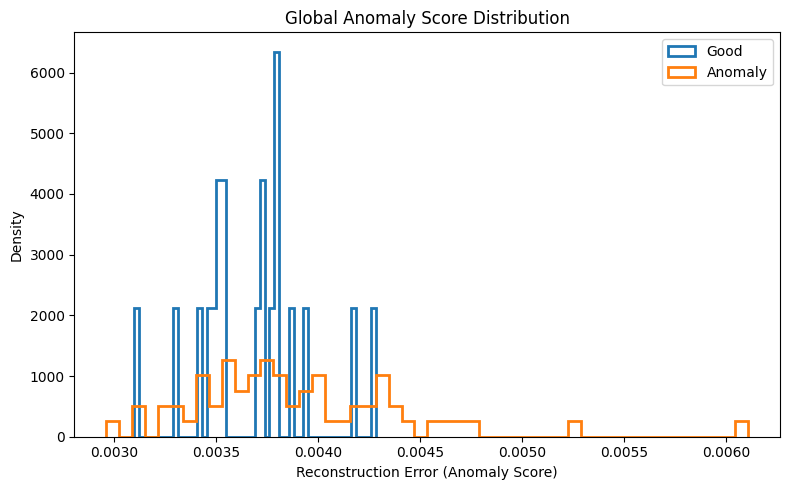

In [6]:
plt.figure(figsize=(8,5))

plt.hist(
    anomaly_scores[labels == 0],
    bins=50,
    density=True,
    histtype="step",
    linewidth=2,
    label="Good"
)

plt.hist(
    anomaly_scores[labels == 1],
    bins=50,
    density=True,
    histtype="step",
    linewidth=2,
    label="Anomaly"
)

plt.xlabel("Reconstruction Error (Anomaly Score)")
plt.ylabel("Density")
plt.title("Global Anomaly Score Distribution")
plt.legend()
plt.tight_layout()
plt.show()


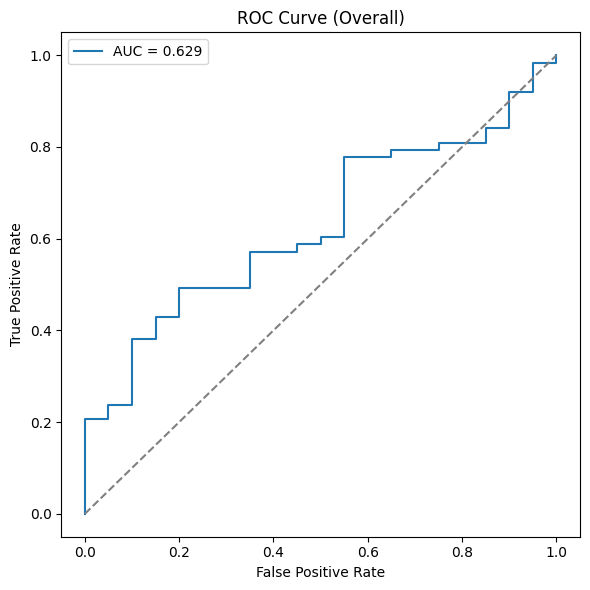

Overall ROC-AUC: 0.6285714285714287


In [7]:
fpr, tpr, thresholds = roc_curve(labels, anomaly_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Overall)")
plt.legend()
plt.tight_layout()
plt.show()

print("Overall ROC-AUC:", roc_auc)


In [8]:
df = pd.DataFrame({
    "score": anomaly_scores,
    "label": labels,
    "category": categories
})

df.head()


,score,label,category
0,0.003398,1,broken_large
1,0.003863,1,broken_large
2,0.003335,1,broken_large
3,0.003498,1,broken_large
4,0.004373,1,broken_large


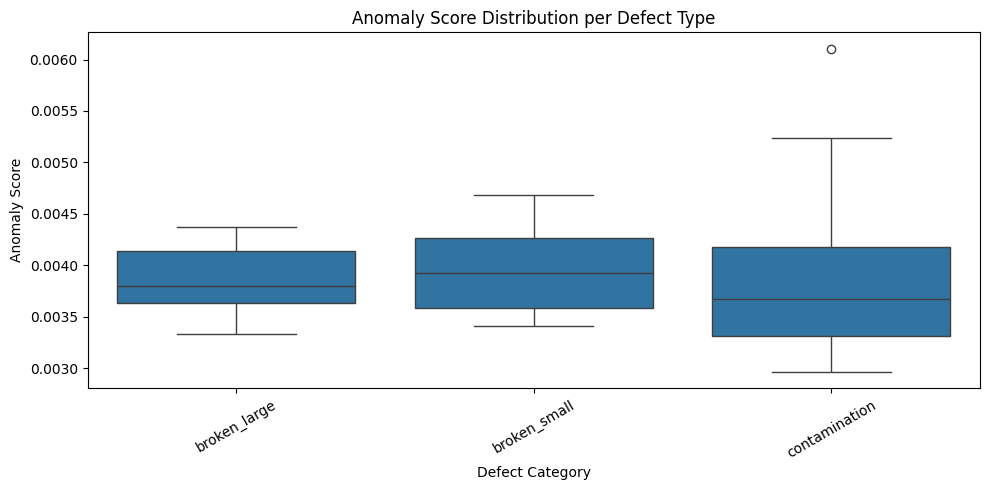

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(
    data=df[df["category"] != "good"],
    x="category",
    y="score"
)
plt.xlabel("Defect Category")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Distribution per Defect Type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [10]:
df.groupby("category")["score"].mean().sort_values(ascending=False)


category
broken_small     0.003949
broken_large     0.003860
contamination    0.003854
good             0.003671
Name: score, dtype: float32

In [11]:
# Threshold based only on NORMAL samples
threshold = np.percentile(anomaly_scores[labels == 0], 75)

print(f"Chosen anomaly threshold: {threshold:.6f}")


Chosen anomaly threshold: 0.003797


In [12]:
y_pred = (anomaly_scores >= threshold).astype(int)
y_true = labels


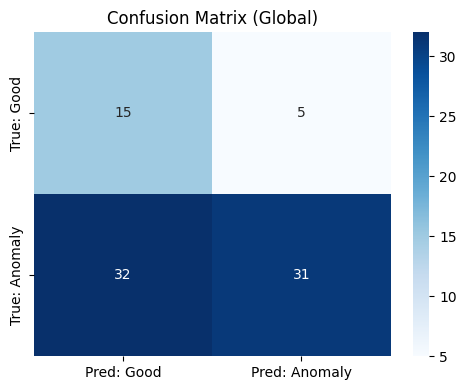

In [13]:
#Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred: Good", "Pred: Anomaly"],
    yticklabels=["True: Good", "True: Anomaly"]
)
plt.title("Confusion Matrix (Global)")
plt.tight_layout()
plt.show()


In [14]:
#Precison, recall etc

print(classification_report(
    y_true,
    y_pred,
    target_names=["Good", "Anomaly"]
))


              precision    recall  f1-score   support

        Good       0.32      0.75      0.45        20
     Anomaly       0.86      0.49      0.63        63

    accuracy                           0.55        83
   macro avg       0.59      0.62      0.54        83
weighted avg       0.73      0.55      0.58        83



In [15]:
"""testing with different percentile thresholds to see tradeoff 
between false postive and false negatives"""
percentiles = [85, 90, 95, 97]
rows = []

for p in range(80, 99, 2):
    t = np.percentile(anomaly_scores[labels == 0], p)
    y_pred = (anomaly_scores >= t).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    rows.append({
        "percentile": p,
        "threshold": t,
        "false_positives": fp,
        "false_negatives": fn,
        "anomaly_recall": tp / (tp + fn),
        "good_recall": tn / (tn + fp)
    })

pd.DataFrame(rows)



,percentile,threshold,false_positives,false_negatives,anomaly_recall,good_recall
0,80,0.003813,4,32,0.492063,0.80
1,82,0.003836,4,35,0.444444,0.80
2,84,0.003860,4,36,0.428571,0.80
3,86,0.003886,3,37,0.412698,0.85
4,88,0.003912,3,38,0.396825,0.85
5,90,0.003957,2,40,0.365079,0.90
6,92,0.004052,2,44,0.301587,0.90
7,94,0.004148,2,46,0.269841,0.90
8,96,0.004207,1,48,0.238095,0.95
9,98,0.004244,1,49,0.222222,0.95


0.0037973658


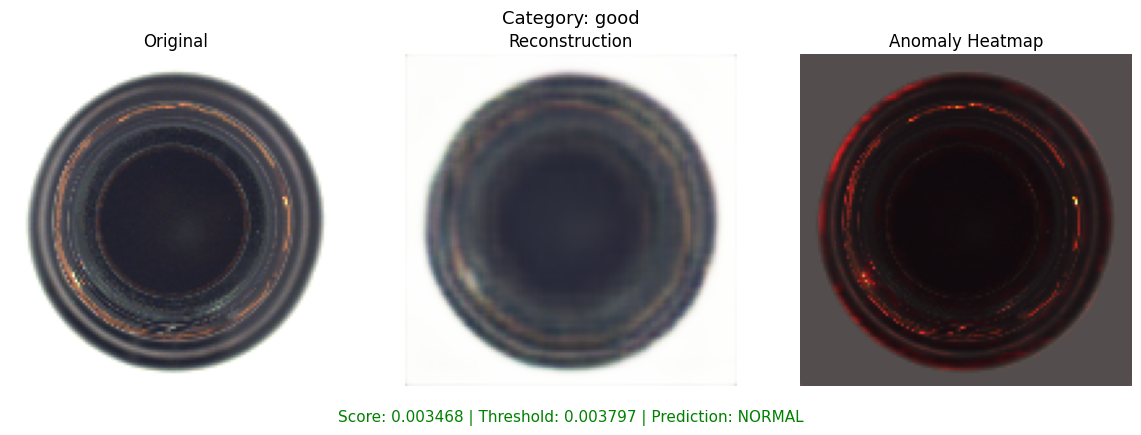

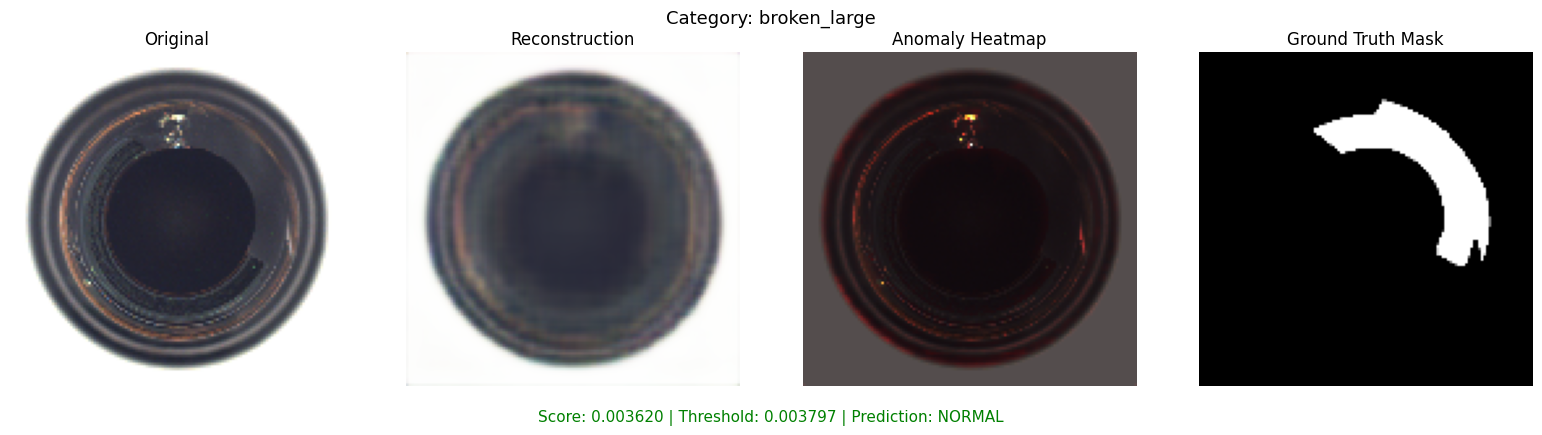

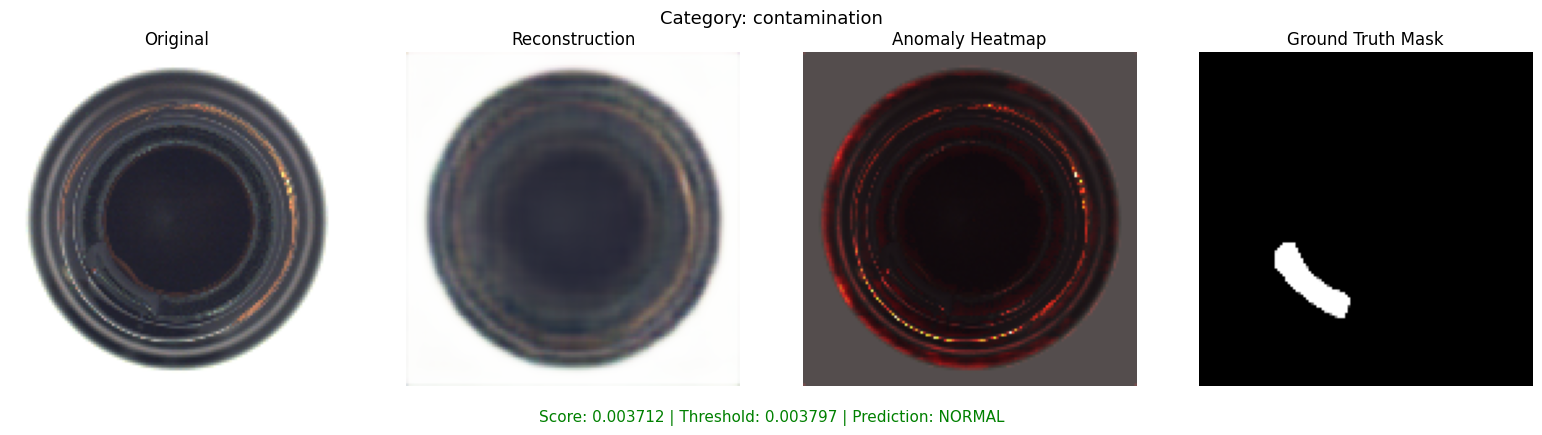

In [16]:
"""Visualisations of random images 
 from each category"""
import random
print(threshold)
sample_folders = [
    test_path / "good",
    test_path / "broken_large",
    test_path / "contamination"
]

gt_path = test_path.parent / "ground_truth"

for folder in sample_folders:
    images = list(folder.glob("*.png"))
    if not images:
        continue

    img_path = random.choice(images)

    x = load_and_preprocess(img_path)
    x_recon = model.predict(x, verbose=0)

    score = anomaly_score(x, x_recon)
    decision = "DEFECT" if score >= threshold else "NORMAL"
    color = "red" if decision == "DEFECT" else "green"

    heatmap = reconstruction_heatmap(x, x_recon, percentile=75)

    show_gt = folder.name != "good"
    ncols = 4 if show_gt else 3

    fig, ax = plt.subplots(1, ncols, figsize=(4 * ncols, 4))

    ax[0].imshow(x[0])
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(x_recon[0])
    ax[1].set_title("Reconstruction")
    ax[1].axis("off")

    ax[2].imshow(x[0])
    ax[2].imshow(heatmap, cmap="hot", alpha=0.7)
    ax[2].set_title("Anomaly Heatmap")
    ax[2].axis("off")

    if show_gt:
        mask_path = gt_path / folder.name / f"{img_path.stem}_mask.png"
        if mask_path.exists():
            mask = cv2.imread(str(mask_path), 0)
            mask = cv2.resize(mask, heatmap.shape[::-1])
            ax[3].imshow(mask, cmap="gray")
            ax[3].set_title("Ground Truth Mask")
            ax[3].axis("off")

    fig.text(
        0.5, -0.05,
        f"Score: {score:.6f} | Threshold: {threshold:.6f} | Prediction: {decision}",
        ha="center",
        fontsize=11,
        color=color
    )

    plt.suptitle(f"Category: {folder.name}", fontsize=13)
    plt.tight_layout()
    plt.show()


<h4>Alternative Anomaly Scoring: Max Reconstruction Error</h4>


In [17]:
max_scores = []
labels = []
categories = []

for defect_dir in test_path.iterdir():
    if not defect_dir.is_dir():
        continue

    category = defect_dir.name
    label = 0 if category == "good" else 1

    for img_path in defect_dir.glob("*.png"):
        x = load_and_preprocess(img_path)
        x_recon = model.predict(x, verbose=0)

        max_scores.append(max_anomaly_score(x, x_recon))
        labels.append(label)
        categories.append(category)

max_scores = np.array(max_scores)
labels = np.array(labels)
categories = np.array(categories)

print("Total test images:", len(max_scores))


Total test images: 83


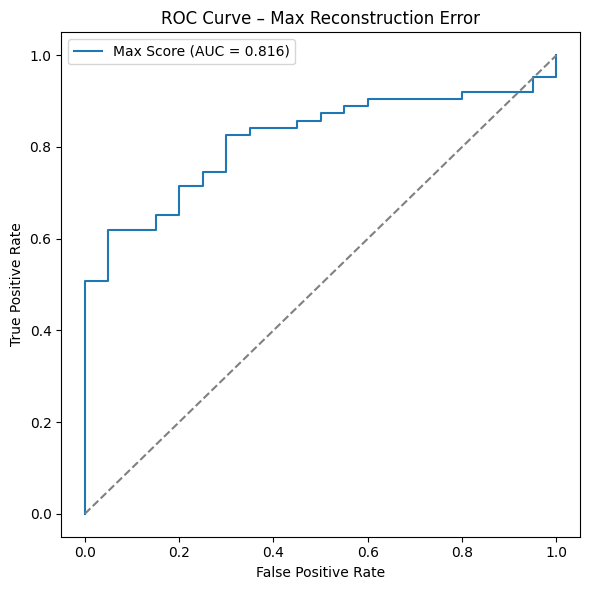

Max-score ROC-AUC: 0.816


In [18]:
fpr, tpr, _ = roc_curve(labels, max_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"Max Score (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Max Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Max-score ROC-AUC: {roc_auc:.3f}")


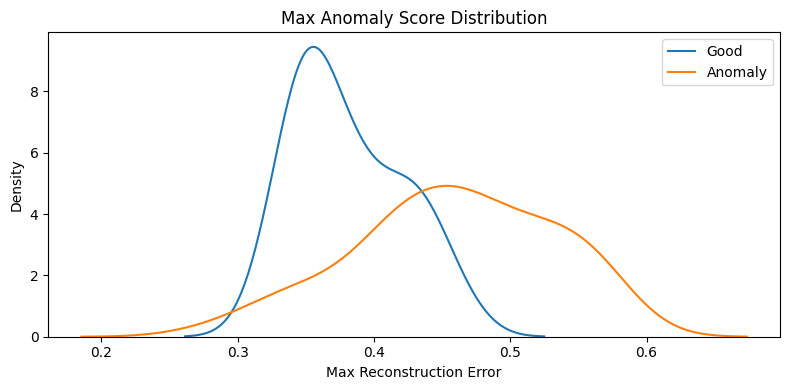

In [19]:
#Max anamoly distribution curve
plt.figure(figsize=(8,4))
sns.kdeplot(max_scores[labels == 0], label="Good")
sns.kdeplot(max_scores[labels == 1], label="Anomaly")
plt.xlabel("Max Reconstruction Error")
plt.title("Max Anomaly Score Distribution")
plt.legend()
plt.tight_layout()
plt.show()


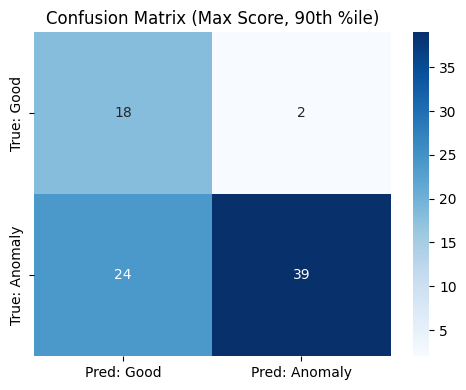

In [20]:
#Confusion matrix
percentile = 90
threshold = np.percentile(max_scores[labels == 0], percentile)

y_pred = (max_scores >= threshold).astype(int)

cm = confusion_matrix(labels, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred: Good", "Pred: Anomaly"],
    yticklabels=["True: Good", "True: Anomaly"]
)
plt.title(f"Confusion Matrix (Max Score, {percentile}th %ile)")
plt.tight_layout()
plt.show()


In [ ]:
# Dataset-level pixel localization evaluation using IoU between anomaly heatmaps and ground-truth masks


from tqdm import tqdm
from utils import binarize_heatmap
from utils import compute_iou

iou_scores = []
per_category_iou = {}

defect_categories = [
    "broken_large",
    "broken_small",
    "contamination"
]

for category in defect_categories:
    img_dir = test_path / category
    gt_dir = test_path.parent / "ground_truth" / category

    category_ious = []

    for img_path in tqdm(list(img_dir.glob("*.png")), desc=f"IoU for {category}"):
        gt_mask_path = gt_dir / f"{img_path.stem}_mask.png"
        if not gt_mask_path.exists():
            continue

        x = load_and_preprocess(img_path)
        x_recon = model.predict(x, verbose=0)

        heatmap = reconstruction_heatmap(x, x_recon, percentile=75)
        pred_mask = binarize_heatmap(heatmap, percentile=75)

        gt_mask = cv2.imread(str(gt_mask_path), 0)
        gt_mask = cv2.resize(gt_mask, heatmap.shape[::-1])
        gt_mask = (gt_mask > 0).astype(np.uint8)

        iou = compute_iou(pred_mask, gt_mask)
        category_ious.append(iou)
        iou_scores.append(iou)

    per_category_iou[category] = np.mean(category_ious) if category_ious else 0.0


print("\nPixel-level IoU Results")
print("-" * 30)
for cat, val in per_category_iou.items():
    print(f"{cat:15s}: Mean IoU = {val:.4f}")

print("-" * 30)
print(f"Overall Mean IoU (defects): {np.mean(iou_scores):.4f}")


IoU for contamination: 100%|██████████| 21/21 [00:02<00:00, 10.30it/s]


Pixel-level IoU Results
------------------------------
broken_large   : Mean IoU = 0.1137
broken_small   : Mean IoU = 0.0563
contamination  : Mean IoU = 0.0736
------------------------------
Overall Mean IoU (defects): 0.0803
